# <center>Оптимизация промышленного производства</center>

Для оптимизации производственных расходов, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

## План работы

1. Назначить цель работы.
2. Ознакомиться с данными и провести их предобработку. 
3. Провести исследовательский анализ данных. Выявить стандартные значения, посмотреть распределения, найти выбросы и аномалии. Возможно потребуется введение синтетических признаков. Также на данном этапе возможно рождение определённых гипотез.
4. Рассмотреть и по возможности отладить несколько моделей машинного обучения, с целью выявить наиболее пригодную модель исходя из сооброжения достичь наилучший показатель целевой метрики. Победившая модель тестируется на новых данных. Возможен анализ важности признаков.
5. Составление выводов и рекомендаций.

  **Цель работы:** построить модель, которая предскажет **итоговую температуру стали.**  
  **Целевая метрика:** MAE ≤ 6.8.

## Описание данных

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

## Ход работы

1. [Исследовательский анализ данных](#Исследовательский-анализ-данных)
2. [Вывод исследовательского анализа](#Вывод-(EDA))
3. [Моделирование](#Моделирование)
4. [Отчёт](#Отчёт-о-проделанной-работе)

# <center>Исследовательский анализ данных</center>

# Подключение необходимых модулей

In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from phik.report import correlation_report, plot_correlation_matrix

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

# Загрузка данных

In [2]:
directory = glob.glob(r"C:\Users\Jemiah\Desktop\final_files\*.csv")

In [5]:
dfs = {}

for _, filename in enumerate(directory):
    dfs[filename[filename.find('data_')+5:]] = pd.read_csv(filename)

In [6]:
# создание красивой маленькой таблички с shape'ами каждого датафрейма
just_view = pd.DataFrame({'file'    : dfs.keys(), 
                          'objects' : [df.shape[0] for df in dfs.values()],
                          'features': [df.shape[1] for df in dfs.values()]})

In [7]:
just_view

,file,objects,features
0,arc_new.csv,14876,5
1,bulk_new.csv,3129,16
2,bulk_time_new.csv,3129,16
3,gas_new.csv,3239,2
4,temp_new.csv,18092,3
5,wire_new.csv,3081,10
6,wire_time_new.csv,3081,10


In [8]:
# первое знакомство с данными произвожу через выведение нескольких строк в цикле
for _, name in enumerate(dfs):
    print(name)
    display(dfs[name].head())
    print('\n\n')

arc_new.csv


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691





bulk_new.csv


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0





bulk_time_new.csv


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47





gas_new.csv


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692





temp_new.csv


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0





wire_new.csv


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN





wire_time_new.csv


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Получилось довольно масштабно. Для облегчения восприятия буду выводить инфо для рассмотрения каждой таблицы отдельно.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

# <center>Целевой признак</center>

Основная задача – предсказать финальную температуру партии. От этого признака мы и начнём наше путешествие, ведь его качество и адекватность в задачах машинного обучения с учителем является основой основ.

In [9]:
dfs['temp_new.csv'].info()

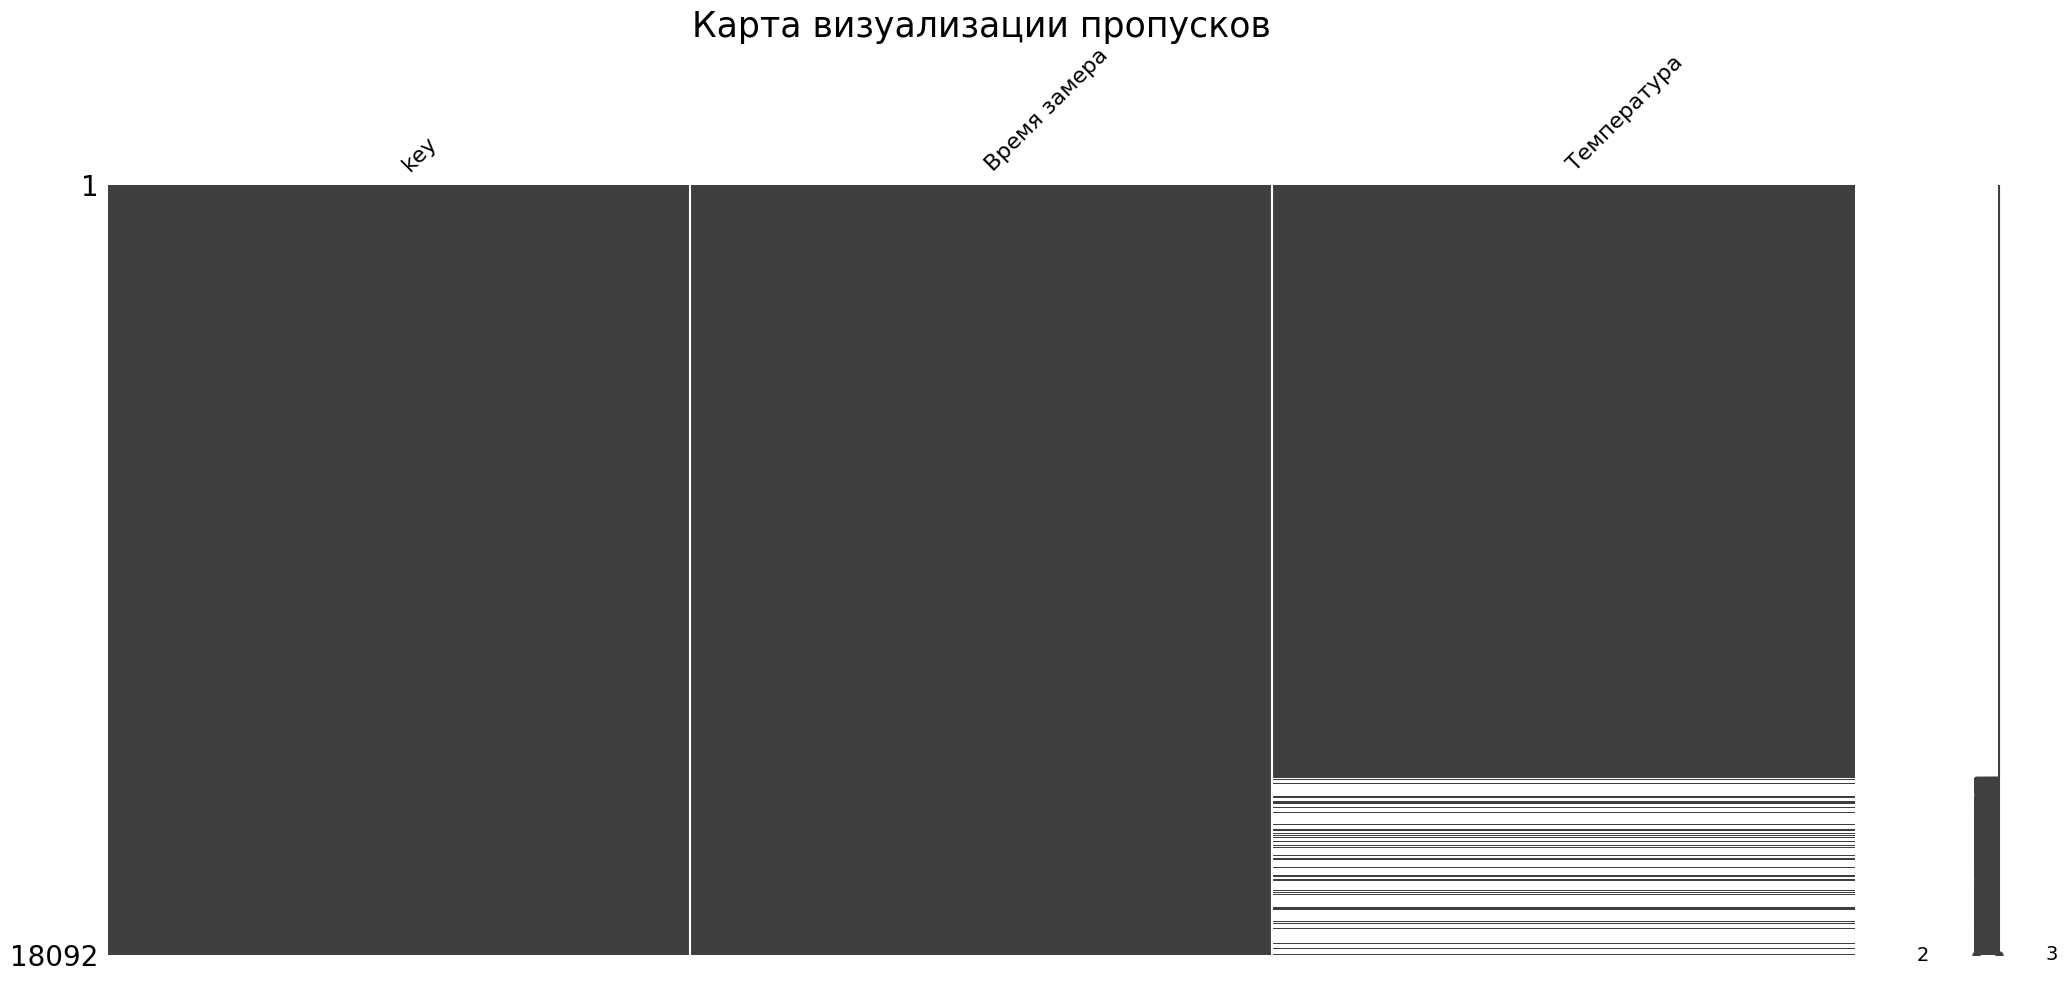

In [10]:
msno.matrix(dfs['temp_new.csv'])
plt.title('Карта визуализации пропусков', fontsize=25)
plt.show()

Первое, что бросается в глаза – пропуски. Второе, что бросается в глаза – тип **object** в столбце с временем. Заполнять пропуски бессмысленно, ведь эти данные - эталон, на них модель должна учиться, поэтому их мы удаляем. Так же пропуски расположены ближе к концу, требуется рассмотретить их подробнее. А вот тип данных изменим на **datetime**.

In [11]:
# число уникальных ковшей (на всякий случай)

len(dfs['temp_new.csv']['key'].unique())

3216

In [12]:
# переименование столбцов

temp_data = dfs['temp_new.csv'].rename(columns={'Время замера': 'time', 
                                                'Температура': 'temp'})

In [13]:
target = pd.DataFrame()

In [14]:
temp_data.groupby(['key', 'time']).min().loc[1]

,temp
time,
2019-05-03 11:02:04,1571.0
2019-05-03 11:07:18,1604.0
2019-05-03 11:11:34,1618.0
2019-05-03 11:18:04,1601.0
2019-05-03 11:25:59,1606.0
2019-05-03 11:30:38,1613.0


In [15]:
# приводим дату к корректному типу данных

temp_data['time'] = pd.to_datetime(temp_data['time'])

Создаю фреймы с временными метками (начальная и конечная метки замера температуры) для дальнейшей проверки адекватности данных.

In [16]:
# объединяем в дф

timeborders = pd.DataFrame(
    {
        'initial_time': temp_data.groupby('key')['time'].min(), 
        'final_time': temp_data.groupby('key')['time'].max()
    }
)

In [17]:
target[['key', 'final_temp']] = temp_data.loc[temp_data['time'].isin(timeborders['final_time']), ['key', 'temp']]

In [18]:
target = target.merge(temp_data.loc[temp_data['time'].isin(timeborders['initial_time']), ['key', 'temp']], on='key')

In [19]:
target.columns = ['key', 'final_temp', 'initial_temp']

In [20]:
target = target[['key', 'initial_temp', 'final_temp']]

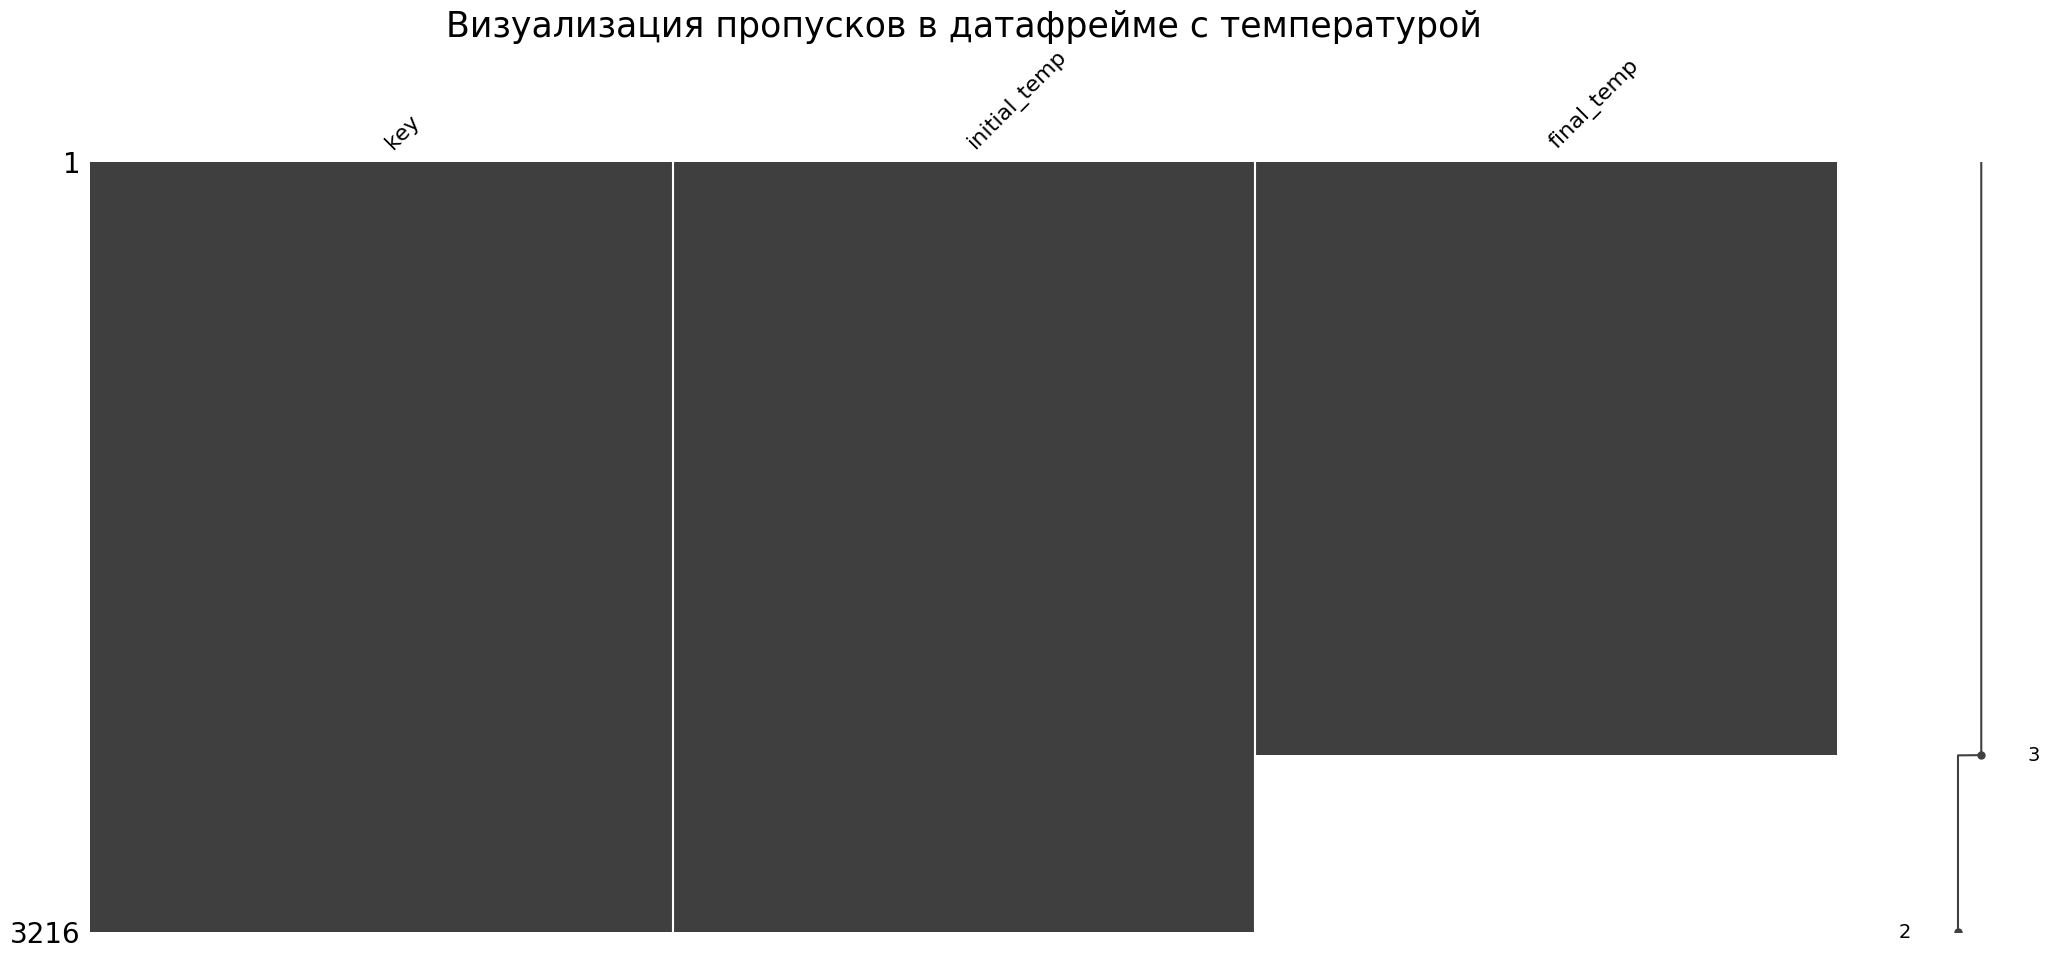

In [21]:
msno.matrix(target)
plt.title('Визуализация пропусков в датафрейме с температурой', fontsize=(25))
plt.show()

In [22]:
target.isna().sum()[2] / len(target)

0.22978855721393035

Одна пятая целевой переменной с пропусками. Придётся от них избавиться.

In [23]:
target = target.dropna()

In [24]:
target

,key,initial_temp,final_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2472,2495,1570.0,1591.0
2473,2496,1554.0,1591.0
2474,2497,1571.0,1589.0
2475,2498,1591.0,1594.0


Посмотрим как дела с самими данными

In [25]:
def build_boxplot(data, title, figsize=(12, 6), color='g'):
    '''
    Функция получает на вход датафреймы и заголовок,
    строит ящики с усами и возвращает данные на границах
    усов
    '''
    plt.figure(figsize=figsize)
    sns.boxplot(data=data, orient='h', color=color)
    plt.title(title)
    plt.show()
    
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)

    IQR = Q3 - Q1

    lower_fence = Q1 - (1.5 * IQR)
    upper_fence = Q3 + (1.5 * IQR)
    
    return lower_fence.values[0], upper_fence.values[0]

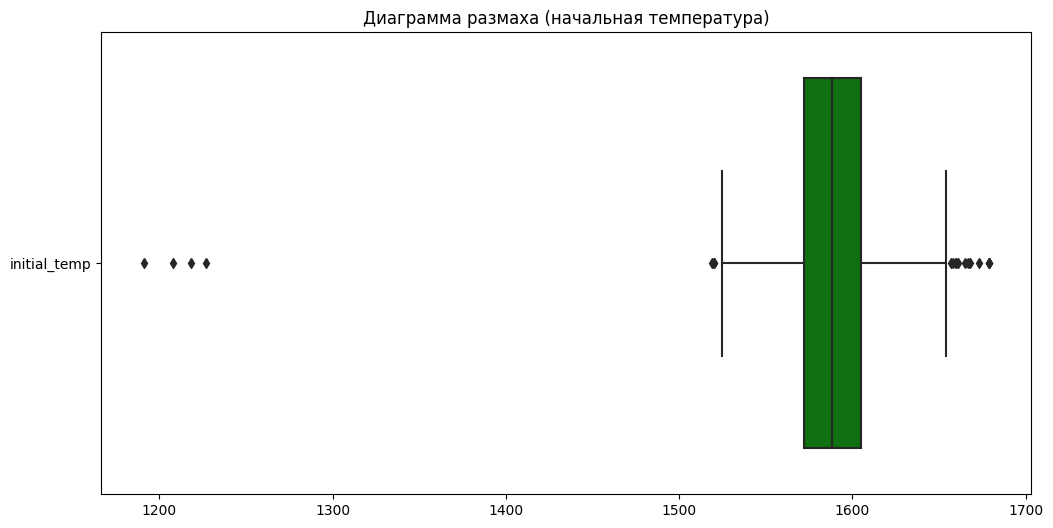

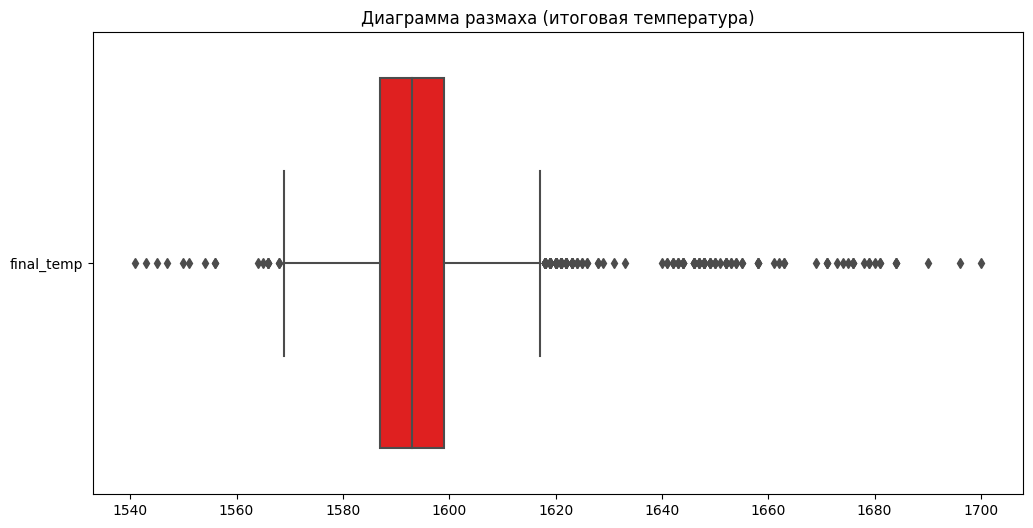

In [26]:
min_init, _ = build_boxplot(data=target[['initial_temp']], title='Диаграмма размаха (начальная температура)')
min_final, max_final = build_boxplot(data=target[['final_temp']], title='Диаграмма размаха (итоговая температура)', color='r')

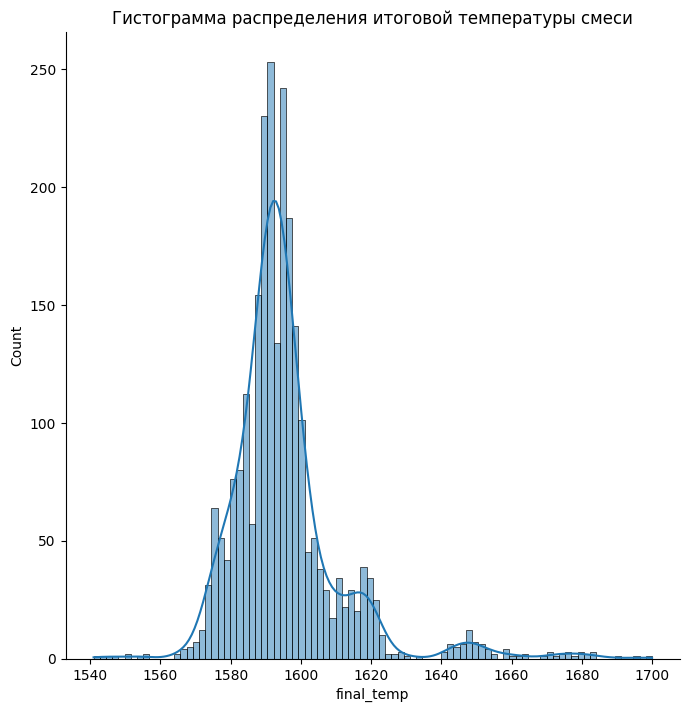

In [27]:
sns.displot(target['final_temp'], kde=True, height=7)
plt.title('Гистограмма распределения итоговой температуры смеси')
plt.show()

Распределение немного скошенно вправо.

Датафрейм с целевым признаком готов. Выбросы учетны и будут обработаны в главе с составлением модели.

# <center>Модельные признаки</center>

### Параметры электродов

In [30]:
# посмотрим всё ли в порядке с типами данных

dfs['arc_new.csv'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [31]:
# для удобства создаю отдельный датафрейм

arc_data = dfs['arc_new.csv']

In [32]:
# присваиваю столбцам новые названия

arc_data = arc_data.rename(columns={'Начало нагрева дугой': 'start', 
                                    'Конец нагрева дугой': 'stop',
                                    'Активная мощность': 'active_power',
                                    'Реактивная мощность': 'reactive_power'})

In [33]:
# изменение типа данных на корректный

arc_data['start'] = pd.to_datetime(arc_data['start'])
arc_data['stop']  = pd.to_datetime(arc_data['stop'])

Как вечный студент физфака приведу немного рассуждений о мощности.

Мощность – это скорость потребления энергии определённой системой (**[1 Дж/c] = [1 Вт]**). Активная мощность характеризует ту часть энергии, которая может быть использована потребителем для совершения некоторой работы. Реактивная мощность характеризует ту часть энергии, которая накапливается в электрических и магнитных полях (в соответствии с некоторыми свойствами данной системы), а затем возвращается обратно в цепь.  
  
Изначально прочитав задачу: "комбинат решил снизить потребление электроэнергии", мне показалось что важно учитывать обе характеристики, поскольку реактивную мощность можно скомпенсировать, а значит информация о её влиянии на траты энергии в общем смогут помочь предприятию сэкономть. Однако техническое задание состоит в предсказании температуры, виновником которой является только активная мощность. За переработку нам никто не платит, поэтому придерживаясь технического задания, реактивную мощность мы удаляем :) 

In [34]:
arc_data = arc_data.drop('reactive_power', axis=1)

In [35]:
# временные метки не так информативны как само время затраченное на нагрев
arc_data['heat_time'] = (arc_data['stop'] - arc_data['start']).dt.total_seconds()
arc_data = arc_data.drop(['start', 'stop'], axis=1)

In [36]:
arc_data = arc_data.groupby('key').sum()

In [37]:
# костыль для нормального отображения графиков
power_plot = pd.DataFrame(arc_data['active_power'])
time_plot = pd.DataFrame(arc_data['heat_time'])

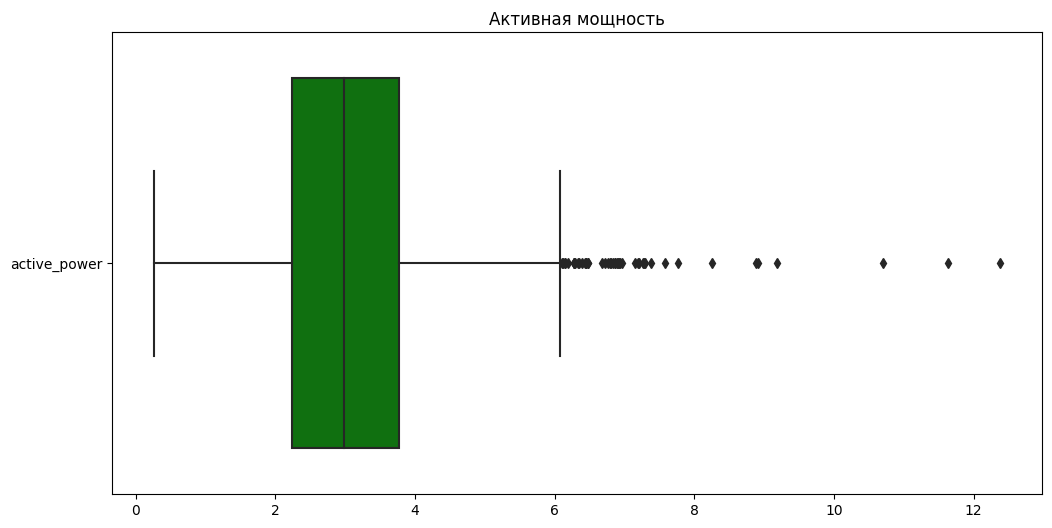

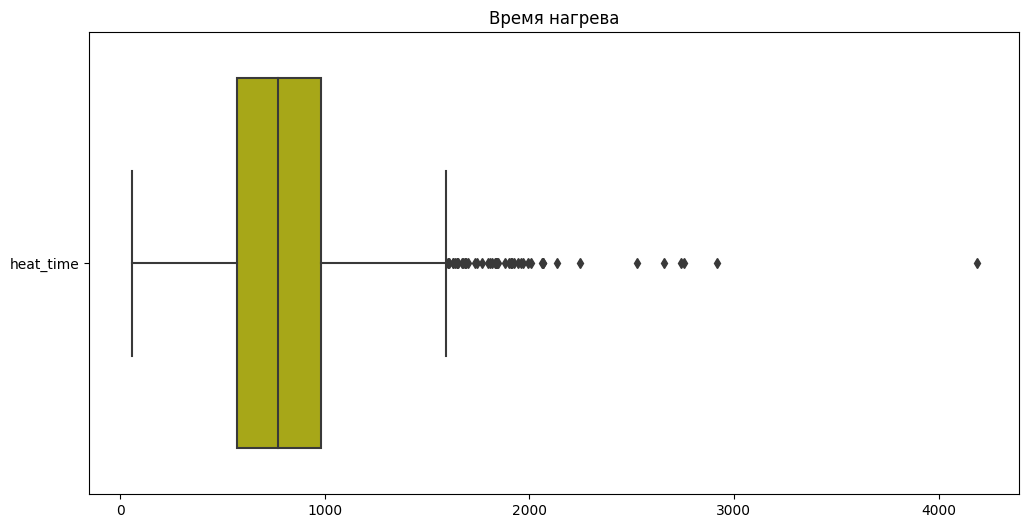

In [38]:
# диаграмма для мощности
min_power, max_power = build_boxplot(data=power_plot, title='Активная мощность')

# диаграмма для времени
min_time, max_time = build_boxplot(data=time_plot, title='Время нагрева', color='y')

In [39]:
arc_data = pd.DataFrame(arc_data).reset_index()

In [40]:
print((arc_data.active_power > 6).sum())
print((arc_data.heat_time > 1700).sum())

53
35


Выбросов в обоих колонках не много, поэтому на трейне их можно отбросить.

### Информация о продувке газом

In [41]:
gas = dfs['gas_new.csv'].groupby('key').sum()

In [42]:
# snake_case

gas.rename(columns={'Газ 1': 'gas'}, inplace=True)

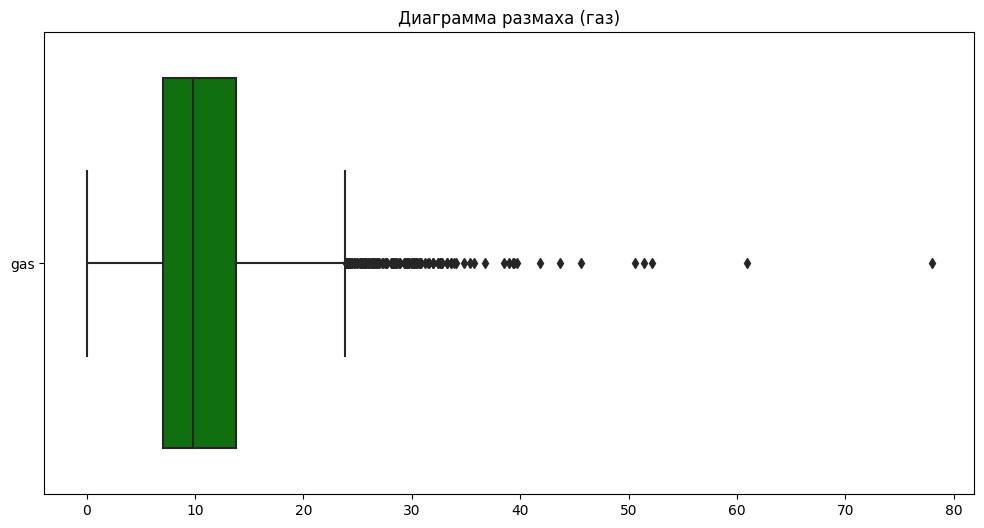

In [43]:
min_gas, max_gas = build_boxplot(pd.DataFrame(gas['gas']), title='Диаграмма размаха (газ)')

In [44]:
# предел отсечки

sum(gas['gas'] > max_gas)

126

126 значений за границей отсечки. Возможно стоит узнать у заказчика являются ли эти данные нормальными.

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>
С выбросами - обязательно учти)

### Информация о сыпучих материалах

In [45]:
# создаю отдельный датафрейм для сыпучих компонентов

bulk_data = dfs['bulk_new.csv']

In [46]:
# меняю название столбцов приводя к snake_case

bulk_data.rename(columns=lambda s: str.lower(s.replace(" ", "_")), inplace=True)

In [47]:
# создаю отдельный датафрейм для сыпучих компонентов

bulk_data = dfs['bulk_new.csv']

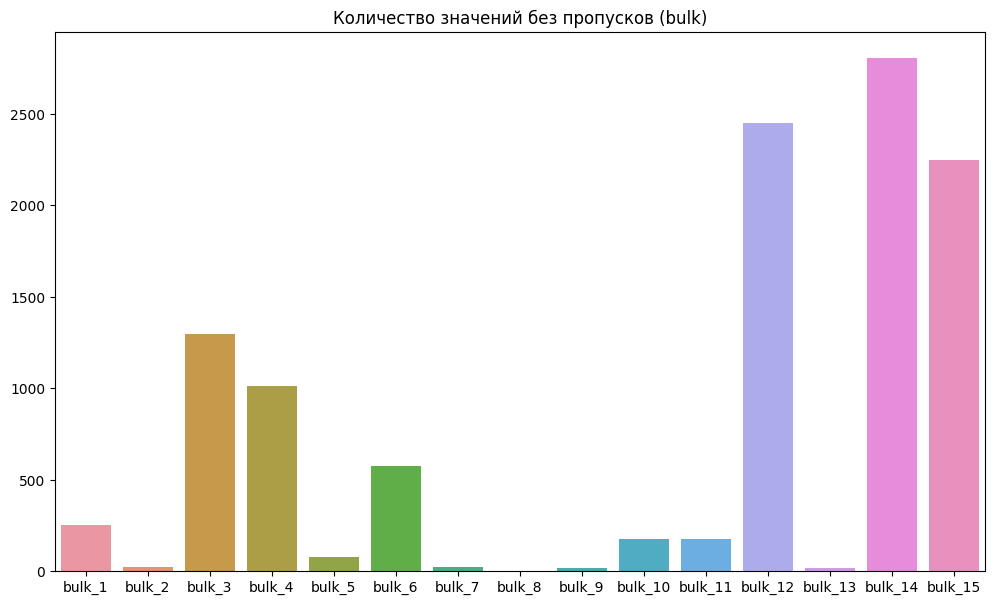

In [48]:
bulk_counter = bulk_data.drop('key', axis=1)

# тут график
fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(x=bulk_counter.columns.tolist(), y=bulk_counter.count())
plt.title('Количество значений без пропусков (bulk)')
# [ax.bar_label(bar) for bar in ax.containers] # подпись значений
plt.show()

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>
Тоже рабочий вараинт, ОК.

В некоторых столбцах данных не достаточно, чтобы модель могла корректно распознать закономерность. Думаю, что значения меньше 1200 можно попробовать объединить в один класс.

### Информация о проволочных материалах

In [49]:
# создаю отдельный датафрейм для проволочных материалов

wire_data = dfs['wire_new.csv']

In [50]:
# меняю название столбцов приводя к snake_case

wire_data.rename(columns=lambda s: str.lower(s.replace(" ", "_")), inplace=True)

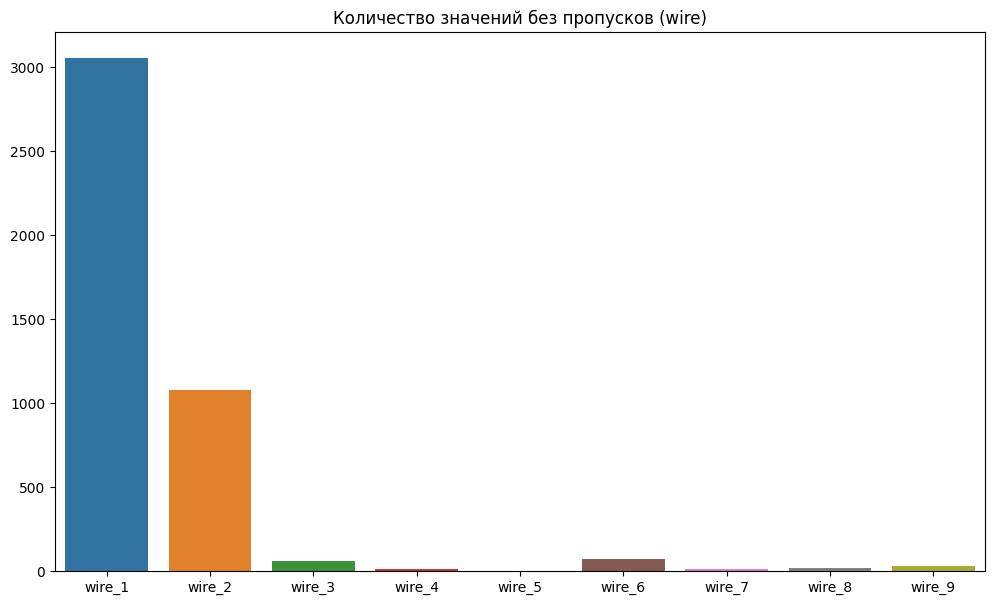

In [51]:
wire_counter = wire_data.drop('key', axis=1)

# тут график
fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(x=wire_counter.columns, y=wire_counter.count())
plt.title('Количество значений без пропусков (wire)')
# [ax.bar_label(bar) for bar in ax.containers] # подпись значений
plt.show()

Аналогичная беда со значениями. Всё что меньше 3000 вероятно объединим

In [52]:
adds_correlation = bulk_data.merge(wire_data, on='key')

C:\Users\Jemiah\anaconda3\envs\final_project\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable bulk_8 for analysis 1. Dropping this column
  warnings.warn(
C:\Users\Jemiah\anaconda3\envs\final_project\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable wire_5 for analysis 1. Dropping this column
  warnings.warn(


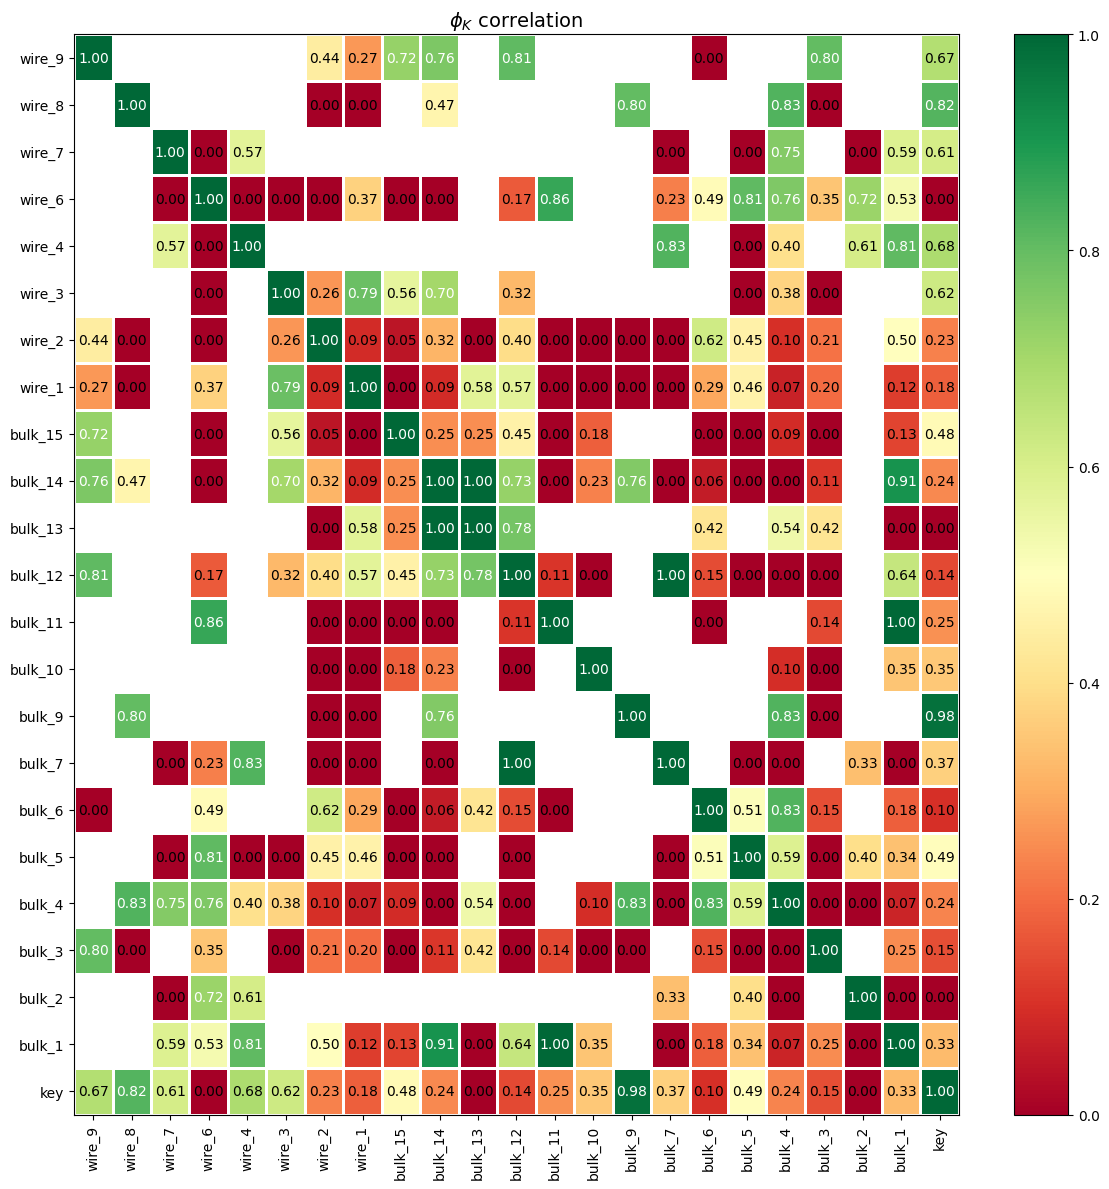

In [53]:
interval_cols = adds_correlation.columns.tolist()
phik_overview = adds_correlation.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map='RdYlGn',
                        title='$\phi_K$ correlation', 
                        figsize=(12, 12))

In [54]:
# # удаление диагонали из матрицы корреляций
# v = phik_overview.values.copy()
# i = j = np.arange(np.min(v.shape))
# v[i, j] = np.nan

# # находим столбцы с корреляцией > 0.7
# new = pd.DataFrame(v, phik_overview.index, phik_overview.columns)
# new_1 = new[new > 0.7].count()
# good_adds = new_1[(new_1 == 0).values == True].index.tolist()

Некоторые признаки имеют избыточную коллинеарность и должны быть удалены в виду избыточности.

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>
ОК, Дмитрий, с первичным анализом - понятно. Есть и аналитика, и графика, и локальные выводы!! Это верно.<br>
    
Добавь, пожалуйста, общий вывод по разделу, важно знать какое качество данных - что ожидается в предобработке. Буду ждать со следующей итерацией)<br>
<br>
С вопросами - ОТЛИЧНО. Очень видно, что проработан исходный материал - это здорово!!!!!<br>
Постарался ответить на них.<br>
Если возникнут ещё или не до конца эти раскрыты - обязательно пиши!!! Да и всегда в чате сможем встретиться. Ну или напиши со следующей итреацией. Постараюсь ответить быстро!<br>
Что ж, тогда вперёд к успешному моделированию)<br><br>
    
И ещё замечу: <br>
1) ковш - это физический объект моделирования. Поэтому, если берёмся удалять что-то не верное, то удаляем сразу объект моедлирования! нам нужно отобрать только те ковши, по которым есть информация во всех таблицвх. Т.е. обязательно должна быть какая-то "движуха":) <br>
2) по ковшу на производственном этапе. Если данных нет - значит не качественно выгрузили данные. И такие ковши  - удаляем из работы. И мержевание по иннер тут как раз поможет избавиться от лишних партий. Посомтри, пожалуйста.

# <center>Вывод (EDA)</center>

Для решения поставленно задачи нами было получено 7 датасетов, относящихся к этапу производственного процесса. Нам нужно было составить модель прогнозирующую температуру стали. Из 7 датасетов 5 имеют наибольшую значимость для моделировани, 2 могут быть использованы для проверки адекватности данных, поэтому в итоговую таблицу не вошли.  
  
Анализ распределений показал, что большая часть данных имеет выбросы. Статистически значимый выброс был обнаружен с распределении итоговых температур, остальные могут являться стандартной практикой, поэтому разибраться с ними будет на этапе моделирования. 
  
Данные имеют пропуски, которые стоит исключить. Пропущенные значения являются ошибкой при выгрузке (т.к. данные, вероятно записываются машинным методом), поэтому занулять пропуски не стоит. В первую очередь нас интересуют строки в которых не пропущен таргет, затем строки в которых недостаточно данных, чтобы модель смогла выявлять закономерности.  
  
Некоторые признаки будут объединены в виду немногочисленности (**bulk & wire**), из-за отстутствия значимости в рамках решения данной задачи **reactive_power** был удалён. Был введён новый признак с временным промежутком нагрева.

# <center>Моделирование</center>

In [55]:
RANDOM_STATE = 8052023

Данные просмотрены, внесены некоторые коррективы, но некоторую предобработку итогового датафрейма требуется провести.

## Предобработка данных

### Компоновка датафрейма

In [56]:
# начинаем с таргета
model_data = pd.DataFrame(target)

In [57]:
# model_data['bulk_added'] = bulk_counter.count(axis=1) # количество добавлений сыпучих примесей

In [58]:
bulk_final_data = bulk_counter[bulk_counter.count()[bulk_counter.count() > 1200].index.tolist()] # оставляю столбцы выше порога

In [59]:
bulk_counter['bulk_sum'] = bulk_counter[bulk_counter.count().index.tolist()].sum(axis=1) # суммирую все

In [60]:
bulk_counter['other_bulk'] = bulk_counter[bulk_counter.count()\
                                         [bulk_counter.count() <= 1200].index.tolist()].sum(axis=1) # суммирую остальные

In [61]:
bulk_final_data = bulk_final_data.join(bulk_counter[['other_bulk', 'bulk_sum']]).join(bulk_data['key']) # итоговый дф для булков

In [62]:
bulk_final_data

,bulk_3,bulk_12,bulk_14,bulk_15,other_bulk,bulk_sum,key
0,NaN,206.0,150.0,154.0,43.0,553.0,1
1,NaN,206.0,149.0,154.0,73.0,582.0,2
2,NaN,205.0,152.0,153.0,34.0,544.0,3
3,NaN,207.0,153.0,154.0,81.0,595.0,4
4,NaN,203.0,151.0,152.0,78.0,584.0,5
...,...,...,...,...,...,...,...
3124,170.0,252.0,130.0,206.0,0.0,758.0,3237
3125,126.0,254.0,108.0,106.0,0.0,594.0,3238
3126,NaN,158.0,270.0,88.0,114.0,630.0,3239
3127,NaN,NaN,192.0,54.0,26.0,272.0,3240


In [63]:
# wire_counter['wires_added'] = wire_counter.count(axis=1) # количество добавлений проволочных примесей

In [64]:
wire_final_data = wire_counter[wire_counter.count()[wire_counter.count() > 3000].index.tolist()] # оставляю столбцы выше порога

In [65]:
wire_counter['wire_sum'] = wire_counter[wire_counter.count().index.tolist()].sum(axis=1) # суммирую все

In [66]:
wire_counter['other_wire'] = wire_counter[wire_counter.count()\
                                         [wire_counter.count() <= 3000].index.tolist()].sum(axis=1) # суммирую остальные

In [67]:
wire_final_data = wire_final_data.join(wire_counter[['other_wire', 'wire_sum']]).join(wire_data['key']) # итоговый дф для вайров

In [68]:
wire_final_data

,wire_1,other_wire,wire_sum,key
0,60.059998,0.00000,60.059998,1
1,96.052315,0.00000,96.052315,2
2,91.160157,0.00000,91.160157,3
3,89.063515,0.00000,89.063515,4
4,89.238236,9.11456,98.352796,5
...,...,...,...,...
3076,38.088959,0.00000,38.088959,3237
3077,56.128799,0.00000,56.128799,3238
3078,143.357761,0.00000,143.357761,3239
3079,34.070400,0.00000,34.070400,3240


In [69]:
# присоединяем признаки
model_data = model_data\
    .merge(arc_data, how='inner', on='key')\
    .merge(bulk_final_data.groupby('key').sum(), how='inner', on='key')\
    .merge(wire_final_data.groupby('key').sum(), how='inner', on='key')\
    .merge(gas, how='inner', on='key')

Признаки мощности и времени имеют высокую степень корреляции, поэтому, чтобы не терять данные, объединяем их в один признак: работа (work)

In [70]:
model_data['work'] = model_data['active_power'] * model_data['heat_time']
model_data = model_data.drop(['active_power', 'heat_time'], axis=1)

In [75]:
# посмотрим имеет ли датафрейм дубликаты
model_data.duplicated().sum()

0

Для данной работы я выбрал 4 типа моделей:
  
* **Линейная регрессия**
* **Дерево решений**
* **Градиентный бустинг CatBoost**
* **Градиентный бустинг XGBoost**

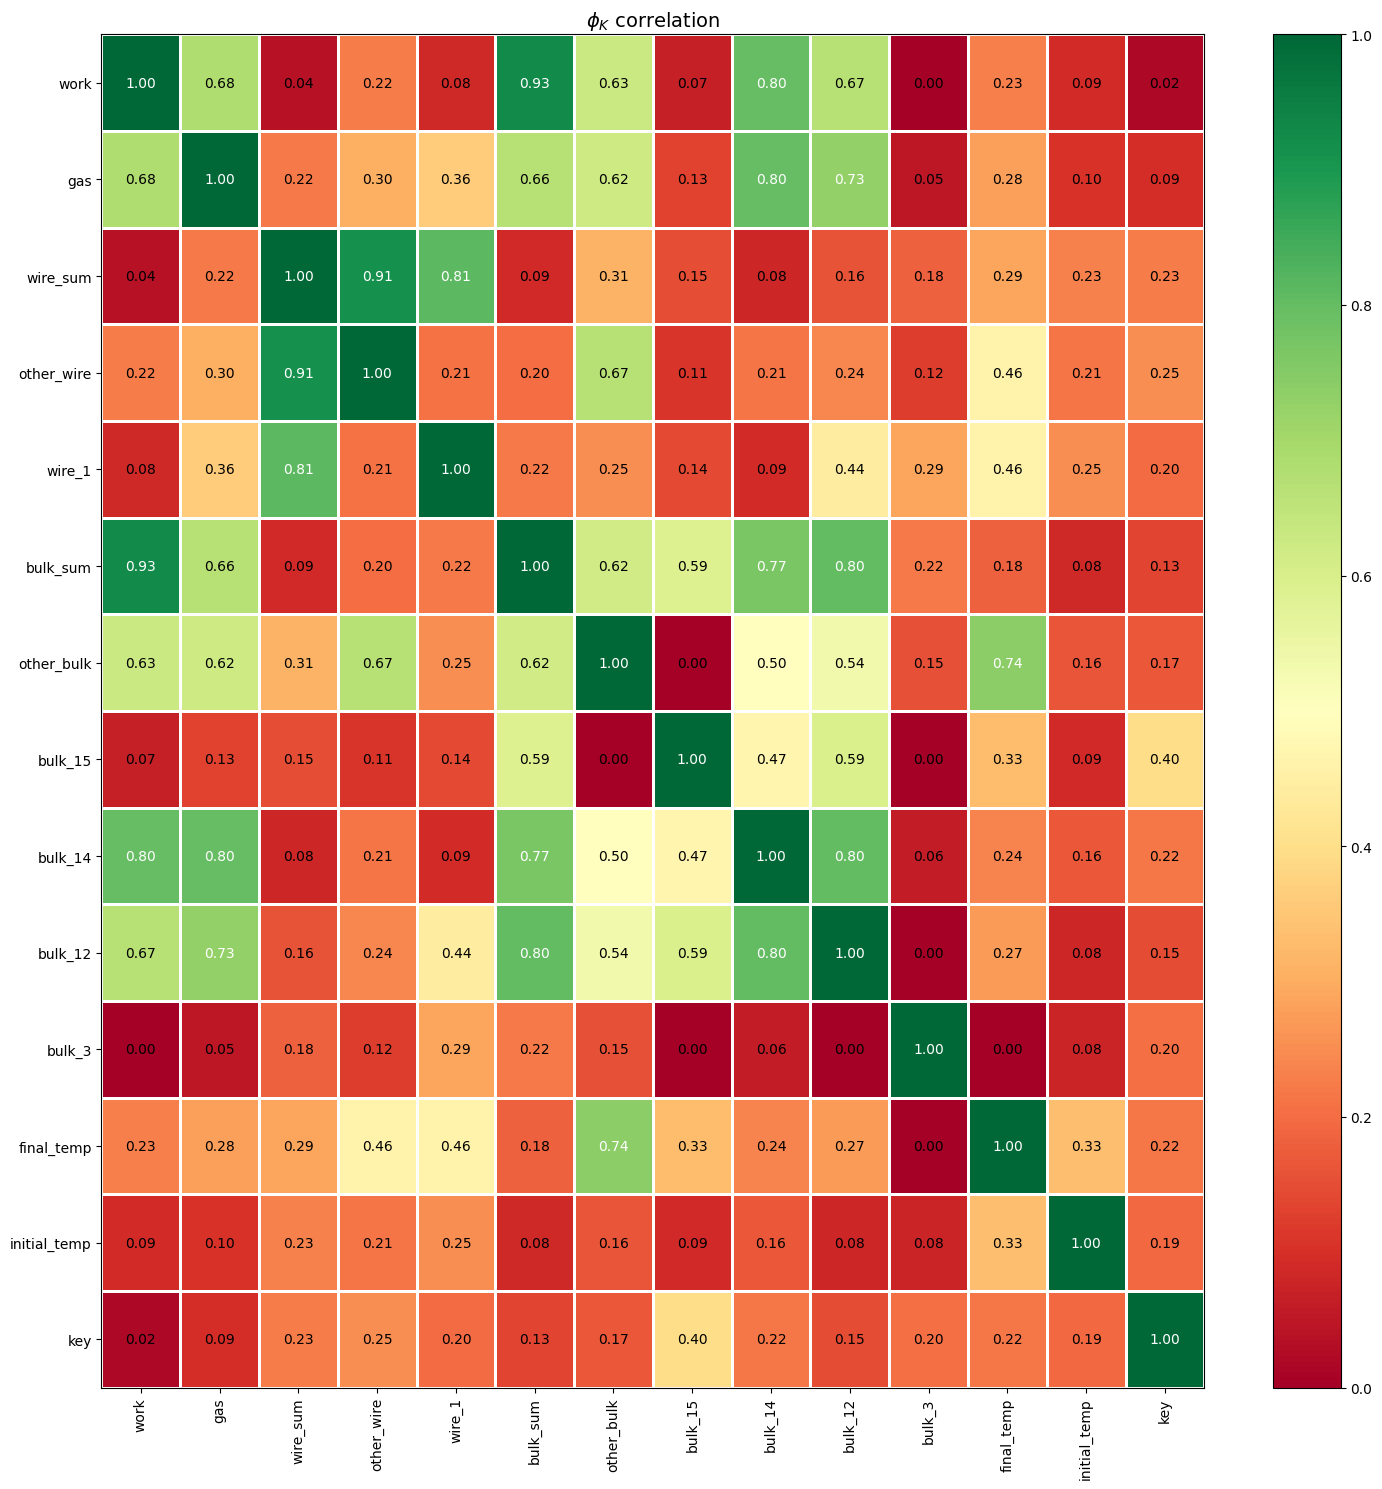

In [77]:
# проверка на мультиколлинеарность 
interval_cols = model_data.columns.tolist()
phik_overview = model_data.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map='RdYlGn',
                        title='$\phi_K$ correlation', 
                        figsize=(15, 15))

В связи с часто встречающейся высокой корреляцией от линейной регрессии стоит отказаться

In [79]:
model_data.isna().sum()

key             0
initial_temp    0
final_temp      0
bulk_3          0
bulk_12         0
bulk_14         0
bulk_15         0
other_bulk      0
bulk_sum        0
wire_1          0
other_wire      0
wire_sum        0
gas             0
work            0
dtype: int64

In [80]:
model_data = model_data.dropna()

In [82]:
X_train, X_test, y_train, y_test = train_test_split(model_data.drop(['final_temp'], axis=1), 
                                                    model_data['final_temp'], 
                                                    test_size=0.25,
                                                    random_state=RANDOM_STATE)

## Отчечка выбросов

In [83]:
train_dataset = X_train.join(y_train)

Посмотрим на боксплоты ещё раз

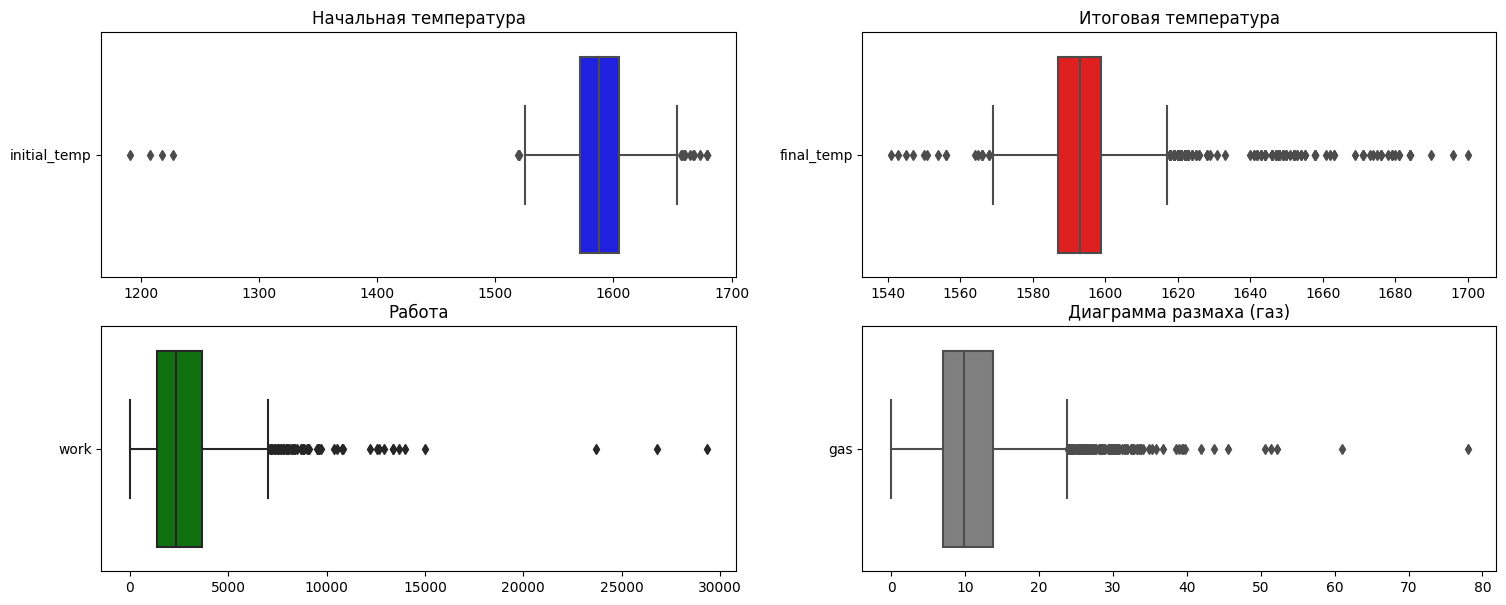

In [84]:
fig = plt.figure(figsize=(18, 7))

plt.subplot(221)
sns.boxplot(data=target[['initial_temp']], orient='h', color='b')
plt.title('Начальная температура')
plt.subplot(222)
sns.boxplot(data=target[['final_temp']], orient='h', color='r')
plt.title('Итоговая температура')

plt.subplot(223)
# диаграмма для работы
sns.boxplot(data=pd.DataFrame(train_dataset['work']), orient='h', color='g')
plt.title('\nРабота')
plt.subplot(224)
sns.boxplot(pd.DataFrame(gas['gas']), orient='h', color='gray')
plt.title('Диаграмма размаха (газ)')

plt.show()

In [85]:
train_dataset = train_dataset.query('initial_temp > 1500 & initial_temp < 1690')

In [86]:
train_dataset = train_dataset.query('final_temp > 1565 & final_temp < 1630')

In [87]:
# поскльку мы ввели новый признак, построили график работы и для работы отбросим выбросы
train_dataset = train_dataset.query('work < 15000')

In [88]:
train_dataset = train_dataset.query('gas < 40')

In [89]:
X_train = train_dataset.drop('final_temp', axis=1)
y_train = train_dataset['final_temp']

In [90]:
X_train = X_train.drop('key', axis=1)
X_test = X_test.drop('key', axis=1)

Переходим к созданию моделей.

In [91]:
def cross_validation(model, parameters, cv_type='rand', train=X_train, target=y_train, n_iter=100, cv=5):
    ''' 
    Функция принимает на вход модель, гиперпараметры
    и данные для кросс-валидации после чего 
    возвращает лучшую модель и её метрику
    cv_type - тип алгоритма подбора параметров
    n_iter - число итераций для RandomizedSearchCV
    cv - кол-во фолдов кросс-валидации
    '''
    if cv_type == 'rand':
        rand = RandomizedSearchCV(model, parameters, n_iter=n_iter, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1, 
                                  random_state=RANDOM_STATE)
        rand.fit(train, target)
        mean_rand = (pd.DataFrame(rand.cv_results_)['mean_test_score'] * -1).min()
        print('Cross-validation MAE: ', round(mean_rand, 2))
        print('Best parameters: ', rand.best_params_)
        return rand.best_estimator_, mean_rand
    else:
        grid = GridSearchCV(model, parameters, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid.fit(train, target)
        mean_grid = (pd.DataFrame(grid.cv_results_)['mean_test_score'] * -1).min()
        print('Cross-validation MAE: ', round(mean_grid, 2))
        print('Best parameters: ', grid.best_params_)
        return grid.best_estimator_, mean_grid

In [92]:
# для сравнения
models = ['tree', 'catboost', 'xgboost']
metrics = []

In [93]:
# дерево 

tree_params = {
    'max_depth': range(10, 20),
    'min_samples_split': range(10, 130),
    'max_leaf_nodes': range(10, 30),
    'max_features': range(10, 110, 10)
}

# кроссвалидация древа
tree, mae = cross_validation(DecisionTreeRegressor(random_state=RANDOM_STATE), tree_params, cv_type='rand')
metrics.append([tree, round(mae, 2)])

Cross-validation MAE:  7.39
Best parameters:  {'min_samples_split': 117, 'max_leaf_nodes': 19, 'max_features': 80, 'max_depth': 12}


In [94]:
# catboost

cb_params = {
    'depth': range(4, 10, 2),
    'learning_rate': np.arange(0.001, 0.01, 0.001),
    'iterations': np.arange(1000, 1500, 100)
}

# кроссвалидация катбуста
catboost, mae = cross_validation(CatBoostRegressor(loss_function='MAE', verbose=0,
                                                   random_state=RANDOM_STATE), cb_params, 
                                                   cv_type='rand', n_iter=10)
metrics.append([catboost, round(mae, 2)])

Cross-validation MAE:  6.53
Best parameters:  {'learning_rate': 0.007, 'iterations': 1400, 'depth': 6}


In [95]:
# xgboost

xgb_params = {
    'n_estimators': range(100, 500),
    'max_depth': np.arange(2, 12, 2),
    'reg_lambda': np.arange(0.05, 0.5, 0.005),
    'learning_rate': np.arange(0.01, 0.26, 0.01)
}

# кроссвалидация хгбуста
xgboost, mae = cross_validation(XGBRegressor(n_jobs=-1, random_state=RANDOM_STATE), 
                                xgb_params, cv_type='rand', n_iter=15)
metrics.append([xgboost, round(mae, 2)])

Cross-validation MAE:  6.67
Best parameters:  {'reg_lambda': 0.32499999999999984, 'n_estimators': 258, 'max_depth': 4, 'learning_rate': 0.04}


In [96]:
models_dict = dict(zip(models, metrics))

In [97]:
def selection(models_dictionary):
    min_value = 10
    # сравнение
    for item in models_dictionary.items():
        if models_dictionary[item[0]][1] < min_value:
            min_value = models_dictionary[item[0]][1]
            winner = item[0]
            model = models_dictionary[item[0]][0]
    print('Winner: ', winner)
    return model

In [98]:
model = selection(models_dict)

Winner:  catboost


## Тестрование

С победителем определились - теперь финальный тест!

In [99]:
final_model = model.fit(X_train, y_train)

In [100]:
print('Итоговая метрика: ', round(mean_absolute_error(model.predict(X_test), y_test), 3))

Итоговая метрика:  6.381


## Сравнение с глупым регрессором (baseline)

In [101]:
dummy = DummyRegressor().fit(X_train, y_train)

In [102]:
mean_absolute_error(dummy.predict(X_test), y_test)

8.016705198001354

Наша модель работает лучше чем дамми-регрессор со стратегией "среднее значение"

## Отбор признаков

Посмотрим какой вклад каждый признак вносит в таргет. Воспользуемся mutual information из пакета sklearn

SelectKBest(k=8,
            score_func=<function mutual_info_regression at 0x0000018D57E4C3A0>)

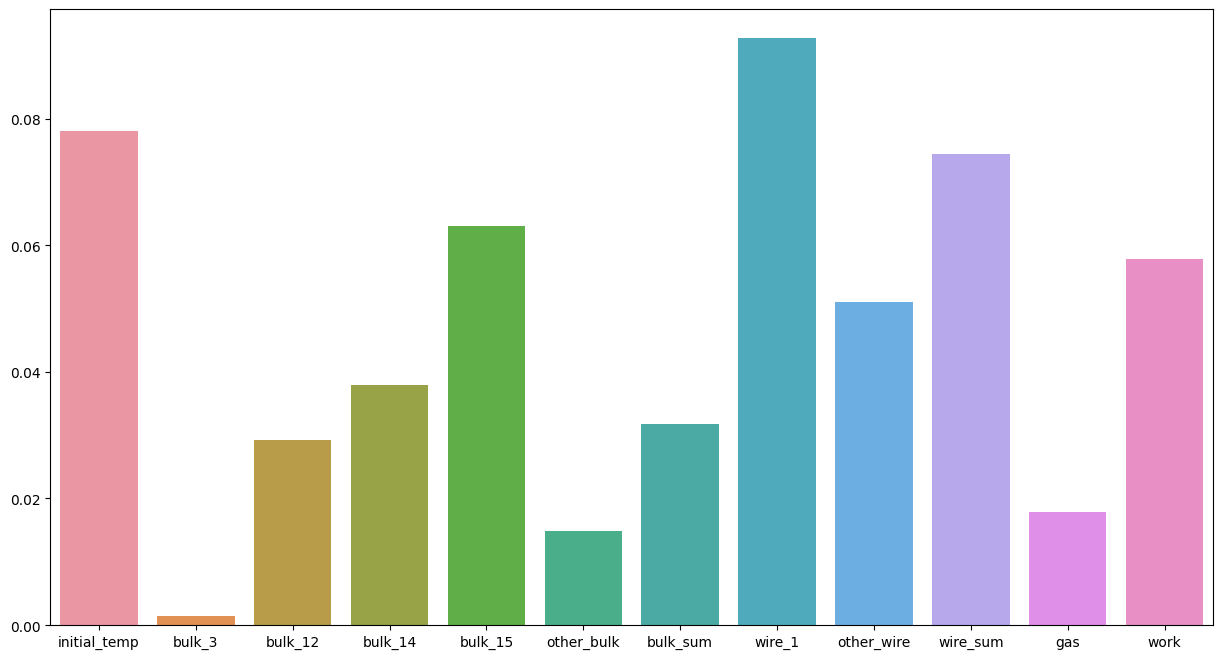

In [103]:
from sklearn.feature_selection import mutual_info_regression, SelectKBest
plt.figure(figsize=(15, 8))

mi = mutual_info_regression(X_train, y_train, random_state=RANDOM_STATE)
sns.barplot(x=X_train.columns.tolist(), y=mi)

feature_selector = SelectKBest(mutual_info_regression, k=8)
feature_selector.fit(X_train, y_train)

In [104]:
X_new = X_train[feature_selector.get_feature_names_out().tolist()]
X_new_test = X_test[feature_selector.get_feature_names_out().tolist()]

In [105]:
feature_selector.get_feature_names_out().tolist()

['initial_temp',
 'bulk_12',
 'bulk_14',
 'bulk_15',
 'wire_1',
 'other_wire',
 'wire_sum',
 'work']

In [106]:
mutual_model = model.fit(X_new, y_train)

In [107]:
mean_absolute_error(mutual_model.predict(X_new_test), y_test)

6.493511440223495

Метрика незначительно ухудшилась.

# <center>Отчёт о проделанной работе</center>

<div style="text-align: justify">Металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали.
Нашей задачей было построение модели машинного обучения которая на основе предоставленных данных будет предсказывать итоговую температуру смехи в сталеварочном ковше.</div>
    
Мы придерживались следующего плана:  

1. Назначить цель работы.
2. Ознакомиться с данными и провести их предобработку. 
3. Провести исследовательский анализ данных. Выявить стандартные значения, посмотреть распределения, найти выбросы и аномалии. Возможно потребуется введение синтетических признаков. Также на данном этапе возможно рождение определённых гипотез.
4. Рассмотреть и по возможности отладить несколько моделей машинного обучения, с целью выявить наиболее пригодную модель исходя из сооброжения достичь наилучший показатель целевой метрики. Победившая модель тестируется на новых данных. Возможен анализ важности признаков.
5. Составление выводов и рекомендаций.

Целью работы была модель машинного обучения, предсказывающая итоговую температуру с метрикой **MAE ≤ 6.8**.  

На моменте знакомства с данными обнаружились следующие недочёты:
* Ближе к концу датафрейма с целевой переменной наблюдались многочисленные пропуски целевой переменной
* Множественные пропуски содержат датафреймы с данными о примесях, вероятно связанные с особенностями рассматриваемых процессов (для достижения нужной кондиции каждая партия требует добавление разных примесей)
* Данные имеют статистически аномальные значения неизвестной природы (возможно уточнение у заказчика)  

<div style="text-align: justify">Поскольку целевая является опорным значением для модели машинного обучения все пропуски в этом столбце были удалены.
Из данных с примесями были отобраны только те столбцы, которые соответствуют наиболее часто использующимся примесям, а так же введены синтетические признаки: <b>Общая сумма добавок</b> и <b>сумма рекдих добавок</b>.
Аномалии были учтены и отсечены в тренировочных выборках. Был проведён небольшой анализ параметров мощности с физической точки зрения, результатом которого стало <b>удаление реактивной мощности</b> (носит паразитный характер). В связи с высокой степенью коллинеарности активной мощности и времени появился ещё один синтетический признак - <b>работа</b>.</div>
<p><div style="text-align: justify">Для этапа моделирования было отобрано 4 вида моделей из которых проверено только 3. Линейная регрессия не включена в работу из-за наличия высокой степени корреляции у некоторых признаков, что пагубно сказывается на работе линейных моделей. Модели выбирались методом перекрёстной проверки(кросс-валидация) с подбором гиперпараметров для минимизации функции потерь. Наилучшей моделью себя показал градиентный бустинг из библиотеки <b>CatBoost</b> с результатом <b>MAE</b> порядка <b>~6.4</b>, что укладывается в требуемый диапазон.</div></p>
<p>Далее был проведён анализ важности признаков, который показал, что из 12 предложенных признаков 4 вносят небольшой вклад в целевой признак. Их удаление незначительно повлияло на метрику (~1.5%).</p>
<p>Итоговые признаки следующие: ['initial_temp', 'bulk_3', 'bulk_12', 'bulk_14', 'bulk_15', 'other_bulk', 'bulk_sum', 'wire_1', 'other_wire', 'wire_sum', 'gas', 'work']</p>
<p>Итоговые гиперпараметры модели-победителя: 'learning_rate': 0.007, 'iterations': 1400, 'depth': 6, random_state=8052023</p>

## <center>Рекомендации по улучшению</center>

1. Основным шагом в построении любой модели является качество и количество исходных данных. Поэтому первой рекомендацией будет сбор бо́льшего количества данных высокого качества (без пропусков, аномалий, проходящих проверку на адекватность и легко поддающихся интерпретации)
2. Рекомендую произвести более глубой анализ данных для выделения дополнительных признаков, запросить больше данных (имеется в виду признаков, если таковые имеются) о моделируемом процессе для построения более сложной модели (выявления новых закономерностей); подробнее обсудить с заказчиком процесс для лучшего понимания предмета исследования (возможно попросить консультанта)
3. По технической части - более глубокий и подробный подбор гиперпараметров победившей модели (займёт больше машинного времени) и детальный отбор признаков для улучшения качества и быстродействия работы модели  
  
Задача решена. Все пункты текущего плана выполнены.